### 1) 패키지 불러오기

In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data 
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import glob
import cv2
from torchsummary import summary
import time
from torch.autograd import Variable

manualSeed = 12345
random.seed(manualSeed)
torch.manual_seed(manualSeed)

### 2) 경로설정 및 Loader 정의

In [2]:
# 경로 설정
path = '/home/user303/GAN/COVID-19_Radiography_Dataset/Normal/images'# 경로안 모든 이미지
image_paths = glob.glob(path + '/*.png')
# 정렬
image_paths = sorted(image_paths)

In [3]:
image_paths

['/home/user303/GAN/COVID-19_Radiography_Dataset/Normal/images/Normal-1.png',
 '/home/user303/GAN/COVID-19_Radiography_Dataset/Normal/images/Normal-10.png',
 '/home/user303/GAN/COVID-19_Radiography_Dataset/Normal/images/Normal-100.png',
 '/home/user303/GAN/COVID-19_Radiography_Dataset/Normal/images/Normal-1000.png',
 '/home/user303/GAN/COVID-19_Radiography_Dataset/Normal/images/Normal-10000.png',
 '/home/user303/GAN/COVID-19_Radiography_Dataset/Normal/images/Normal-10001.png',
 '/home/user303/GAN/COVID-19_Radiography_Dataset/Normal/images/Normal-10002.png',
 '/home/user303/GAN/COVID-19_Radiography_Dataset/Normal/images/Normal-10003.png',
 '/home/user303/GAN/COVID-19_Radiography_Dataset/Normal/images/Normal-10004.png',
 '/home/user303/GAN/COVID-19_Radiography_Dataset/Normal/images/Normal-10005.png',
 '/home/user303/GAN/COVID-19_Radiography_Dataset/Normal/images/Normal-10006.png',
 '/home/user303/GAN/COVID-19_Radiography_Dataset/Normal/images/Normal-10007.png',
 '/home/user303/GAN/COVID-

In [4]:
# 하이퍼-파라미터
image_size = 64
batch_size = 64
ch = 1
workers=0
ngpu=1

# transform 정의
transform=transforms.Compose([
                               transforms.ToPILImage(),
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                           ])
# ImageDataset 정의
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, index):
        image_path = self.paths[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if self.transform:
            image_tensor = self.transform(image)
            image_tensor = torch.Tensor(image_tensor)
            
        return image_tensor
# loader 정의    
train_dataset = ImageDataset(image_paths[:round(len(image_paths)*0.8)], transform)
test_dataset = ImageDataset(image_paths[round(len(image_paths)*0.8):], transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True, num_workers=workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                          shuffle=False, num_workers=workers)
# device gpu 정의
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

### 3) 각종 함수 정의

In [5]:
np.random.seed(4)

noise_category = "gauss"
def add_noise(noise_typ,image):
    #Gaussian Noisy
    if noise_typ == "gauss":
        image = np.array(image)
        noisy = image + 0.1 *  np.random.normal(loc=0,scale=1.,size=image.shape)
        noisy = torch.Tensor(noisy)
        return noisy
    
    #Salt & Pepper Noisy
    elif noise_typ == "s&p":
        bt,ch,row,col= image.shape
        s_vs_p = 0.5
        amount = 0.05
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * 4096 * s_vs_p)
        print(num_salt)
        coords = [np.random.randint(0,i,3) for i in image.shape[1:]]
        print(coords)
        out[tuple(coords)] = 1
        # Pepper mode
        num_pepper = np.ceil(amount * 4096 * (1. - s_vs_p))
        coords = [np.random.randint(0, i ,3) for i in image.shape[1:]]
        out[tuple(coords)] = 0
        out = torch.Tensor(out)
        return out
    
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        noisy = torch.Tensor(noisy)
        return noisy
    
    # Speckle Noisy
    elif noise_typ =="speckle":
        noisy = np.random.normal(loc=0,scale=1.,size=image.shape)
        noisy = image+ image * 0.1 *noisy
        noisy = torch.Tensor(noisy)
        return noisy
    
    
# psnr 함수 정의
import math
def PSNR(img1, img2, min_value=0, max_value=1):
    """
    psnr 을 계산해준다.
    이미지가 [0., 255] 이면 min_value=0, max_valu=255 로 해주고,
    이미지가 [-1,1]의 범위에 있으면 min_value=-1, max_valu=1 로 설정 해준다.
    """
    if type(img1) == torch.Tensor:
        mse = torch.mean((img1 - img2) ** 2)
    else:
        mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = max_value - min_value
    return 10 * math.log10((PIXEL_MAX ** 2) / mse)

* 잡음 추가 함수의 타입인 noise_category(변수)를 변경하면서 학습
* 위 페이지 기본은 gaussian 잡음

### 4) 모형 정의 

#### Deformable

In [6]:
random.seed(manualSeed)
torch.manual_seed(manualSeed)
class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 bias=False):

        super(DeformableConv2d, self).__init__()
        
        assert type(kernel_size) == tuple or type(kernel_size) == int

        kernel_size = kernel_size if type(kernel_size) == tuple else (kernel_size, kernel_size)
        self.stride = stride if type(stride) == tuple else (stride, stride)
        self.padding = padding
        
        self.offset_conv = nn.Conv2d(in_channels, 
                                     2 * kernel_size[0] * kernel_size[1],
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=self.padding, 
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)
        
        self.modulator_conv = nn.Conv2d(in_channels, 
                                     1 * kernel_size[0] * kernel_size[1],
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=self.padding, 
                                     bias=True)

        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)
        
        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      bias=bias)

    def forward(self, x):
        #h, w = x.shape[2:]
        #max_offset = max(h, w)/4.

        offset = self.offset_conv(x)#.clamp(-max_offset, max_offset)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))
        
        x = torchvision.ops.deform_conv2d(input=x, 
                                          offset=offset, 
                                          weight=self.regular_conv.weight, 
                                          bias=self.regular_conv.bias, 
                                          padding=self.padding,
                                          mask=modulator,
                                          stride=self.stride,
                                          )
        return x

#### Generator 모형

In [7]:
random.seed(manualSeed)
torch.manual_seed(manualSeed)
ch =1
# red-cnn 모형 응용
class RED_CNN(nn.Module):
    def __init__(self, out_channels=96):
        super(RED_CNN, self).__init__()
        self.conv_first = nn.Conv2d(ch, out_channels, kernel_size=5, stride=1, padding=0)
        self.conv = DeformableConv2d(out_channels, out_channels, kernel_size=5, stride=1, padding=0)
        self.deconv = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=5, stride=1, padding=0)
        self.deconv_last = nn.ConvTranspose2d(out_channels, ch, kernel_size=5, stride=1, padding=0)
        self.sn2 = nn.utils.spectral_norm(self.deconv)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_channels)
        self.ln = nn.InstanceNorm2d(out_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        residual1 = x.clone()
        layer = self.relu(self.conv_first(x))
        layer = self.relu((self.conv(layer)))
        residual2 = layer.clone()
        layer = self.relu((self.conv(layer)))
        residual3 = layer.clone()
        layer = self.relu((self.conv(layer)))
        residual4 = layer.clone()
        layer = self.relu((self.conv(layer)))
        residual5 = layer.clone()
        layer = self.relu((self.conv(layer)))
        residual6 = layer.clone()
        layer = self.relu((self.conv(layer)))


    
        # decoder
        layer = self.deconv(self.relu(layer))
        layer += residual6
        layer = self.deconv(self.relu(layer))
        layer += residual5
        layer = self.deconv(self.relu(layer))
        layer += residual4
        layer = self.deconv(self.relu(layer))
        layer += residual3
        layer = self.deconv(self.relu(layer))
        layer += residual2
        layer = self.deconv(self.relu(layer))
        layer = self.deconv_last(self.relu(layer))
        layer += residual1
        layer = self.sigmoid(layer)
        return layer
    
generator = RED_CNN().to(device)
#summary(generator, (ch,image_size,image_size),batch_size = batch_size)

In [8]:
summary(generator, (ch,image_size,image_size),batch_size = batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 96, 60, 60]           2,496
              ReLU-2           [64, 96, 60, 60]               0
            Conv2d-3           [64, 50, 56, 56]         120,050
            Conv2d-4           [64, 25, 56, 56]          60,025
  DeformableConv2d-5           [64, 96, 56, 56]               0
              ReLU-6           [64, 96, 56, 56]               0
            Conv2d-7           [64, 50, 52, 52]         120,050
            Conv2d-8           [64, 25, 52, 52]          60,025
  DeformableConv2d-9           [64, 96, 52, 52]               0
             ReLU-10           [64, 96, 52, 52]               0
           Conv2d-11           [64, 50, 48, 48]         120,050
           Conv2d-12           [64, 25, 48, 48]          60,025
 DeformableConv2d-13           [64, 96, 48, 48]               0
             ReLU-14           [64, 96,

#### Discriminator 모형

In [9]:
from torchvision import models
resnet18_pretrained = models.resnet18(pretrained=True)
num_classes = 1
resnet18_pretrained.conv1 =nn.Conv2d(1,64,kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet18_pretrained = torch.nn.Sequential(*(list(resnet18_pretrained.children())[:-1]))
resnet18_pretrained.conv1 =nn.Conv2d(512,1,kernel_size=(1, 1), bias=False)
resnet18_pretrained.activation = nn.Sigmoid()
resnet18_pretrained

/home/user303/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/user303/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [10]:
summary(resnet18_pretrained.to(device), (ch,image_size,image_size),batch_size = batch_size)
discriminator= resnet18_pretrained.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 64, 32, 32]           3,136
       BatchNorm2d-2           [64, 64, 32, 32]             128
              ReLU-3           [64, 64, 32, 32]               0
         MaxPool2d-4           [64, 64, 16, 16]               0
            Conv2d-5           [64, 64, 16, 16]          36,864
       BatchNorm2d-6           [64, 64, 16, 16]             128
              ReLU-7           [64, 64, 16, 16]               0
            Conv2d-8           [64, 64, 16, 16]          36,864
       BatchNorm2d-9           [64, 64, 16, 16]             128
             ReLU-10           [64, 64, 16, 16]               0
       BasicBlock-11           [64, 64, 16, 16]               0
           Conv2d-12           [64, 64, 16, 16]          36,864
      BatchNorm2d-13           [64, 64, 16, 16]             128
             ReLU-14           [64, 64,

In [11]:
# from torchvision import models
# import torch

# resnet18_pretrained = models.resnet18(pretrained=True)
# num_classes = 1
# resnet18_pretrained = torch.nn.Sequential(*(list(resnet18_pretrained.children())[:-1]))
# resnet18_pretrained.conv1 =nn.Conv2d(512,1,kernel_size=(1, 1), bias=False)
# resnet18_pretrained.activation = nn.Sigmoid()

# summary(resnet18_pretrained.to(device), (ch,image_size,image_size),batch_size = batch_size)
# discriminator= resnet18_pretrained.to(device)

### 5) 학습

In [12]:
criterion = nn.BCELoss()
criterion2 = nn.MSELoss()
beta1=0.5
optimizerD = optim.Adam(discriminator.parameters(), lr=0.00002, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=0.00002, betas=(beta1, 0.999))

In [13]:
total_iters = 0
num_epochs = 200
start = time.time()
beta1 = 0.5
label = torch.FloatTensor(batch_size)
train_losses = []
train_psnrs = []
lossD = []
lossG = []

real_label = 1
fake_label = 0

for epoch in range(1, num_epochs):
    loss_G = 0
    loss_D = 0
    psnr = 0
    generator.train()

    for iter_, (x) in enumerate(train_loader):
        # discriminator 
        discriminator.zero_grad()
        batch_size = x.size(0)
        label.resize_(batch_size,1,1,1).fill_(real_label) # 실제

        inputv = Variable(x).to(device) # x를 input으로 넣음
        # real data 학습
        labelv = Variable(label).to(device) # 1로 채워짐
        
        output = discriminator(inputv) 
        errD_real = criterion(output, labelv) # x랑 labelv를 통한 real_err 구함
        errD_real.backward()
        
        # fake data 학습
        x_noise = add_noise(noise_category,x).to(device)
        fake = generator(x_noise.clip(0,1).float())
        labelv = Variable(label.fill_(fake_label)).to(device) # 0으로 채워짐
        output = discriminator(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()

        
        errD = errD_real + errD_fake
        loss_D += errD.item()/len(train_loader)
        optimizerD.step()

        # generator
        generator.zero_grad()      
        errG = criterion(fake.clip(0,1), x.to(device))
        #print(errG)
        loss_G += errG.item()/len(train_loader)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()
        
        
        fake = fake.reshape((-1,ch,image_size,image_size))
        x =x.reshape((-1,ch,image_size,image_size))
        
        train_psnr = PSNR(fake, x.to(device))
        psnr += train_psnr/len(train_loader)
    lossD.append(loss_D) # D loss 저장
    lossG.append(loss_G) # G loss 저장
    train_psnrs.append(psnr) # psnr 저장
    print("EPOCH [{}/{}], ITER [{}/{}] \nloss_G: {:.8f}, \nloss_D: {:.8f}, psnr : {:1f}".format(epoch, 
                                                                                            num_epochs, iter_+1, 
                                                                                            len(train_loader), loss_G,loss_D, psnr))

    
end = time.time()
all_time = start - end
print(all_time)    

EPOCH [1/200], ITER [128/128] 
loss_G: 0.58362242, 
loss_D: 1.37607873, psnr : 18.645536
EPOCH [2/200], ITER [128/128] 
loss_G: 0.56194527, 
loss_D: 0.79140608, psnr : 21.929443
EPOCH [3/200], ITER [128/128] 
loss_G: 0.55626213, 
loss_D: 0.49680731, psnr : 23.457967
EPOCH [4/200], ITER [128/128] 
loss_G: 0.55398346, 
loss_D: 0.31904851, psnr : 24.276292
EPOCH [5/200], ITER [128/128] 
loss_G: 0.55236666, 
loss_D: 0.27641470, psnr : 24.956133
EPOCH [6/200], ITER [128/128] 
loss_G: 0.55122332, 
loss_D: 0.15840807, psnr : 25.489252
EPOCH [7/200], ITER [128/128] 
loss_G: 0.55028891, 
loss_D: 0.14809764, psnr : 25.969784
EPOCH [8/200], ITER [128/128] 
loss_G: 0.54958965, 
loss_D: 0.09823748, psnr : 26.364436
EPOCH [9/200], ITER [128/128] 
loss_G: 0.54912192, 
loss_D: 0.10095115, psnr : 26.662988
EPOCH [10/200], ITER [128/128] 
loss_G: 0.54865674, 
loss_D: 0.10440477, psnr : 26.943548
EPOCH [11/200], ITER [128/128] 
loss_G: 0.54838480, 
loss_D: 0.05553771, psnr : 27.137319
EPOCH [12/200], ITE

EPOCH [93/200], ITER [128/128] 
loss_G: 0.54529981, 
loss_D: 0.00290488, psnr : 29.831627
EPOCH [94/200], ITER [128/128] 
loss_G: 0.54534312, 
loss_D: 0.00271591, psnr : 29.790577
EPOCH [95/200], ITER [128/128] 
loss_G: 0.54527697, 
loss_D: 0.00145137, psnr : 29.842446
EPOCH [96/200], ITER [128/128] 
loss_G: 0.54535229, 
loss_D: 0.00150018, psnr : 29.845499
EPOCH [97/200], ITER [128/128] 
loss_G: 0.54525190, 
loss_D: 0.00147919, psnr : 29.853537
EPOCH [98/200], ITER [128/128] 
loss_G: 0.54524365, 
loss_D: 0.00134402, psnr : 29.875517
EPOCH [99/200], ITER [128/128] 
loss_G: 0.54527216, 
loss_D: 0.22170519, psnr : 29.852949
EPOCH [100/200], ITER [128/128] 
loss_G: 0.54526818, 
loss_D: 0.00666698, psnr : 29.868847
EPOCH [101/200], ITER [128/128] 
loss_G: 0.54516497, 
loss_D: 0.07266974, psnr : 29.876396
EPOCH [102/200], ITER [128/128] 
loss_G: 0.54519320, 
loss_D: 0.00598644, psnr : 29.929490
EPOCH [103/200], ITER [128/128] 
loss_G: 0.54523572, 
loss_D: 0.00567164, psnr : 29.874030
EPOCH 

EPOCH [184/200], ITER [128/128] 
loss_G: 0.54499158, 
loss_D: 0.04945364, psnr : 30.321834
EPOCH [185/200], ITER [128/128] 
loss_G: 0.54497234, 
loss_D: 0.00185117, psnr : 30.339243
EPOCH [186/200], ITER [128/128] 
loss_G: 0.54490628, 
loss_D: 0.00141467, psnr : 30.329214
EPOCH [187/200], ITER [128/128] 
loss_G: 0.54488102, 
loss_D: 0.00109399, psnr : 30.346877
EPOCH [188/200], ITER [128/128] 
loss_G: 0.54492767, 
loss_D: 0.00101767, psnr : 30.316915
EPOCH [189/200], ITER [128/128] 
loss_G: 0.54493452, 
loss_D: 0.00095064, psnr : 30.344758
EPOCH [190/200], ITER [128/128] 
loss_G: 0.54481302, 
loss_D: 0.00102338, psnr : 30.359642
EPOCH [191/200], ITER [128/128] 
loss_G: 0.54496286, 
loss_D: 0.00078662, psnr : 30.361701
EPOCH [192/200], ITER [128/128] 
loss_G: 0.54486498, 
loss_D: 0.02996430, psnr : 30.335391
EPOCH [193/200], ITER [128/128] 
loss_G: 0.54492847, 
loss_D: 0.01602440, psnr : 30.355837
EPOCH [194/200], ITER [128/128] 
loss_G: 0.54488361, 
loss_D: 0.00106947, psnr : 30.358311

In [14]:
import datetime

def convert_seconds_to_kor_time(in_seconds):
    """초를 입력받아 읽기쉬운 한국 시간으로 변환"""
    t1   = datetime.timedelta(seconds=in_seconds)
    days = t1.days
    _sec = t1.seconds
    (hours, minutes, seconds) = str(datetime.timedelta(seconds=_sec)).split(':')
    hours   = int(hours)
    minutes = int(minutes)
    seconds = int(seconds)
    
    result = []
    if days >= 1:
        result.append(str(days)+'일')
    if hours >= 1:
        result.append(str(hours)+'시간')
    if minutes >= 1:
        result.append(str(minutes)+'분')
    if seconds >= 1:
        result.append(str(seconds)+'초')
    return ' '.join(result)
convert_seconds_to_kor_time(np.abs(all_time))

'4시간 25분 52초'

In [ ]:
#torch.save(generator.state_dict(), './model/dedcganresnet50_10.pt') 

### 6) 테스트 데이터 결과 확인

In [13]:
generator.load_state_dict(torch.load("/home/user303/3_jihyeheo/졸업논문/hromi_dataset/가우시안잡음/model/dedcganresnet50_8.pt"))

<All keys matched successfully>

In [15]:
#import pytorch_ssim
import torchvision.utils as utils
import kornia.metrics.ssim

mae_loss = nn.L1Loss()
mse_loss = nn.MSELoss()
fake_list = []
noise_list = []

LOSS = 0
psnr = 0
mae = 0
mse = 0
ssim=0
np.random.seed(0)
torch.manual_seed(0)


for x in test_loader:
    #generator.eval()
    with torch.no_grad():
        x = x.view(-1, ch, image_size, image_size)
        #print(x.shape)
        x_noise = add_noise(noise_category,x).to(device).clip(0,1)
    
        pred = generator(x_noise.float()).clip(0,1)
        #print(pred.shape)
        
        loss = criterion(pred, x.to(device))
        #optimizer.step()
        #train_losses.append(loss.item())
        LOSS += loss.item()/len(test_loader)
        #pred = pred.reshape((-1,64,64))
        #x =x.reshape((-1,64,64))
        test_psnr = PSNR(pred, x.to(device))
        psnr += test_psnr/len(test_loader)
        mae += mae_loss(pred,x.to(device))/len(test_loader)
        mse += mse_loss(pred,x.to(device))/len(test_loader)
        ssim += (kornia.metrics.ssim(pred,x.to(device), window_size=11).mean())
        
        fake = pred.detach().cpu()
        noise = x_noise.detach().cpu()
        fake_list.append(utils.make_grid(fake, padding=2, normalize=True))
        noise_list.append(utils.make_grid(noise, padding=2, normalize=True))
        
ssim /= len(test_loader)      
print("RED-DGAN psnr : {:1f}, mae : {:1f}, mse : {:1f}, ssim : {:1f}".format(psnr,mae, mse,ssim))

RED-DGAN psnr : 30.402930, mae : 0.022293, mse : 0.000912, ssim : 0.908714


In [20]:
original_x = test_dataset[42]
image_size=64
noisy_x = add_noise(noise_category,original_x).clip(0,1).to(device)
noise_xx = noisy_x.view(-1,1,image_size,image_size)
pred = generator(noise_xx.float()).clip(0,1)

original_x = np.array(original_x).reshape((1,image_size,image_size))
noisy_x = np.array(noisy_x.to('cpu')).reshape((1,image_size,image_size))
pred = np.array(pred.detach().cpu().numpy()).reshape((1,image_size,image_size))

(-0.5, 63.5, 63.5, -0.5)

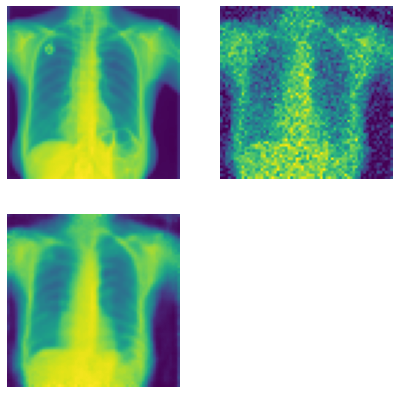

In [21]:
plt.figure(figsize=(7, 7))
plt.subplot(221)
plt.imshow(original_x.transpose(1,2,0))
plt.axis('off')

plt.subplot(222)
plt.imshow(noisy_x.transpose(1,2,0))
plt.axis('off')

plt.subplot(223)
plt.imshow(pred.transpose(1,2,0))
plt.axis('off')


### 7) 시각화

In [18]:
ori = original_x.transpose(1,2,0)#*255.
noi = noisy_x.transpose(1,2,0)#*255.
pre = pred.transpose(1,2,0)#*255.

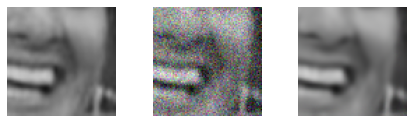

In [19]:
# 사진 일부 확인
plt.figure(figsize=(10, 2))

plt.subplot(141)
plt.imshow(ori[50:200, 50:200])
plt.axis("off")

plt.subplot(142)
plt.imshow(noi[50:200, 50:200], cmap=plt.cm.bone)
plt.axis("off")

plt.subplot(143)
plt.imshow(pre[50:200, 50:200], cmap=plt.cm.bone)
plt.axis("off")

plt.show()

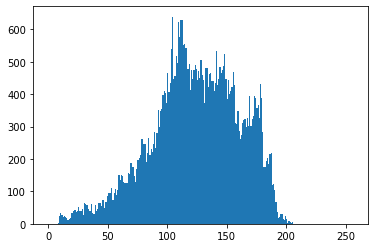

In [20]:
# 픽셀 히스토그램 시각화
ori = original_x.transpose(1,2,0)*255.
pre = pred.transpose(1,2,0)*255.
hist,bins = np.histogram(pre.ravel(),256,[0,256])
plt.hist(pre.ravel(), 256, [0,256]); 
plt.show()

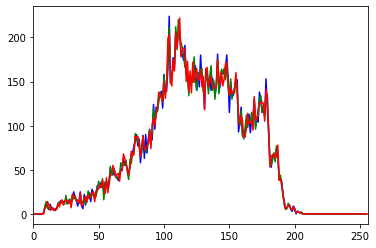

In [21]:
# r,g,b 히스토그램 시각화
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([pre],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

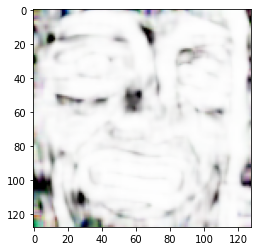

In [22]:
# 원 영상과의 차이
from skimage.metrics import structural_similarity as compare_ssim
score, diff = compare_ssim(ori, pre, full=True,multichannel=True)
plt.imshow((diff*255).astype('int64').clip(0,255))